# Scikit-Optimize methods

Scikit-optimize is another open-source Python library for hyperparameter optimization. It implements several methods for sequential model-based optimization.

The library is very easy to use and provides a general toolkit for Bayesian optimization that can be used for hyperparameter tuning. It also provides support for tuning the hyperparameters of machine learning algorithms offered by the scikit-learn library.

The scikit-optimize is built on top of Scipy, NumPy, and Scikit-Learn.

Scikit-optimize has at least four important features you need to know in order to run your first optimization. Let's look at them in depth now.



### Objective Function
This is a function that will be called by the search procedure. It receives hyperparameter values as input from the search space and returns the loss (the lower the better).

This means that during the optimization process, we train the model with selected hyperparameter values and predict the target feature. Then we evaluate the prediction error and give it back to the optimizer.

The optimizer will decide which values to check and iterate over again. You will learn how to create an objective function in the practical example below.

### Optimizer
This is the function that performs the Bayesian Hyperparameter Optimization process. The optimization function iterates at each model and the search space to optimize and then minimizes the objective function.

There are different optimization functions provided by the scikit-optimize library, such as:

__dummy_minimize__ — Random search by uniform sampling within the given bounds.

__forest_minimize__ — Sequential optimization using decision trees.

__gbrt_minimize__ — Sequential optimization using gradient boosted trees.

__gp_minimize__ — Bayesian optimization using Gaussian Processes.


### Procedure

To tune the hyper-parameters of our model we need to:

- define a model
- decide which parameters to optimize
- define the objective function we want to minimize.

### NOTE

Scikit-Optimize will always **minimize** the objective function, so if we want to maximize a function, for example the roc-auc, we need to **negate** the metric. Thus, instead of maximizing the roc-auc, we minimize the -roc-auc.


Scikit-Optimize, or skopt for short, is an open-source Python library for performing optimization tasks.

It offers efficient optimization algorithms, such as Bayesian Optimization, and can be used to find the minimum or maximum of arbitrary cost functions.

Bayesian Optimization provides a principled technique based on Bayes Theorem to direct a search of a global optimization problem that is efficient and effective. It works by building a probabilistic model of the objective function, called the surrogate function, that is then searched efficiently with an acquisition function before candidate samples are chosen for evaluation on the real objective function.

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args

# Load dataset

In [3]:
data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [8]:
X = data.iloc[:,1:-1]
X.head()

,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online
0,25,1,49,91107,4,1.6,1,0,0,1,0,0
1,45,19,34,90089,3,1.5,1,0,0,1,0,0
2,39,15,11,94720,1,1.0,1,0,0,0,0,0
3,35,9,100,94112,1,2.7,2,0,0,0,0,0
4,35,8,45,91330,4,1.0,2,0,0,0,0,0


In [9]:
y = data.iloc[:,-1]
y.head()

0    0
1    0
2    0
3    0
4    1
Name: CreditCard, dtype: int64

In [13]:
y.shape

(5000,)

In [10]:
# the target:
y.value_counts() / len(y)

0    0.706
1    0.294
Name: CreditCard, dtype: float64

In [15]:
# split dataset into a train and test set

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape

((4000, 12), (1000, 12))

# Building base model

In this project, I have implemented XGBoost which is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.

In [17]:
# XGB
import xgboost as xgb

In [21]:
from sklearn.metrics import accuracy_score

gbm = xgb.XGBClassifier(random_state=1000)

gbm.fit(X_train, y_train)

preds = gbm.predict(X_test)
accuracy_score(y_test, preds)

C:\Users\004567\Anaconda3\envs\root3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:00:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\004567\Anaconda3\envs\root3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


0.716

As you see, our baseline model accuracy is 0.716

# Hyperparameter space

Determining the hyperparameter space for all hyperparameter methods.


In [19]:
param_grid = [
    Integer(10, 1000, name='n_estimators'),
    Integer(1, 50, name='max_depth'),
    Real(0.01, 0.99, name='learning_rate'),
    Categorical(['gbtree', 'dart'], name='booster'),
    Real(0.01, 100, name='gamma'),
]

type(param_grid)

list

## 2. Random Search SCIKIT-OPTIMIZE

This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:


If you let randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).


Simply by setting the number of iterations, you have more control over the computing budget you want to allocate to hyperparameter search.


In [23]:
# We design a function to maximize the accuracy, of a GBM,
# with cross-validation

# the decorator allows our objective function to receive the parameters as
# keyword arguments. This is a requirement of Scikit-Optimize.
@use_named_args(param_grid)
def objective(**params):
    
    # model with new parameters
    gbm.set_params(**params)

    # optimization function (hyperparam response function)
    value = np.mean(
        cross_val_score(
            gbm, 
            X_train,
            y_train,
            cv=2,
            n_jobs=-4,
            scoring='accuracy')
    )

    # negate because we need to minimize
    return -value

In [24]:
# dummy_minimize performs the randomized search
import time
start = time.time()

search = dummy_minimize(
    objective,  # the objective function to minimize
    param_grid,  # the hyperparameter space
    n_calls=30,  # the number of subsequent evaluations of f(x)
    random_state=0,
)

end = time.time()
print(end - start)
random_search_run_time = end - start

642.1875545978546


In [25]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % search.fun

'Best score=-0.7410'

Note: Your results may vary given the stochastic nature of the algorithm or evaluation procedure, or differences in numerical precision.

## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

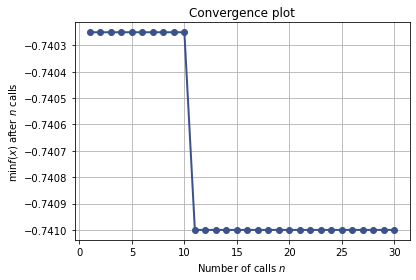

In [26]:
plot_convergence(search)

In [27]:
dim_names = ['n_estimators', 'max_depth', 'learning_rate', 'booster', 'gamma']

In [28]:
# all together in one dataframe, so we can investigate further
random_search_results = pd.concat([
    pd.DataFrame(search.x_iters),
    pd.Series(search.func_vals),
], axis=1)

random_search_results.columns = dim_names + ['accuracy']
random_search_results.sort_values(by='accuracy', ascending=True, inplace=True)

# tmp.sort_values(by='accuracy', ascending=False, inplace=True)
random_search_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
10,301,39,0.667225,gbtree,12.901341,-0.74100
0,569,1,0.600708,dart,42.371243,-0.74025
27,471,46,0.671930,gbtree,31.328701,-0.74025
26,792,33,0.839480,dart,29.750721,-0.74025
25,850,27,0.570807,gbtree,95.275374,-0.74025


# 3. Gaussian process-based Bayesian Optimization.

We are now ready for sequential model-based optimization. Here we use Gaussian process-based Optimization. Bayesian Optimization is a class of iterative optimization methods that focuses on the general optimization setting, where a description of 𝒳 is available, but knowledge of the properties of f is limited. Bayesian Optimization methods are characterized by two features:


__the surrogate model__ -  f ̂, for the function f,


__an acquisition function__ -  computed from the surrogate and used for guiding the selection of the next evaluation point

In [29]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel
import time
start = time.time()

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

end = time.time()
print(end - start)
gp_bayesian_run_time = end - start

483.4329128265381


In [30]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.7410'

In [31]:
gp_.x

[400, 27, 0.5963646497195423, 'gbtree', 14.0475418198134]

## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

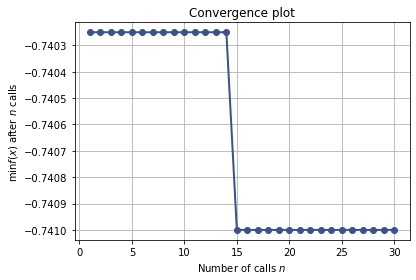

In [32]:
plot_convergence(gp_)

In [33]:
# all together in one dataframe, so we can investigate further
gp_bayesian_results = pd.concat([
    pd.DataFrame(gp_.x_iters),
    pd.Series(gp_.func_vals),
], axis=1)

gp_bayesian_results.columns = dim_names + ['accuracy']
gp_bayesian_results.sort_values(by='accuracy', ascending=True, inplace=True)

# tmp.sort_values(by='accuracy', ascending=False, inplace=True)
gp_bayesian_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
14,400,27,0.596365,gbtree,14.047542,-0.74100
27,362,50,0.010000,dart,11.106282,-0.74025
26,10,12,0.781684,gbtree,46.020260,-0.74025
25,544,39,0.399809,dart,20.434931,-0.74025
24,1000,17,0.285025,gbtree,18.555926,-0.74025


## 4. Bayesian Optimization with Random Forests (SMAC)

Sequential optimisation using decision trees.

A tree based regression model is used to model the expensive to evaluate function func. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the minimum of func with as few evaluations as possible.

In [34]:
# forest_minimize performs Bayesian Optimization 
# using Random Forests as surrogate
start = time.time()

fm_ = forest_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    base_estimator = 'RF', # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

end = time.time()
print(end - start)
rf_bayesian_run_time = end - start

490.37929487228394


In [35]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % fm_.fun

'Best score=-0.7403'

This procedure didn't find as good hyperparameters as the random search or the search with GPs. The accuracy is lower.

## Evaluate convergence of the search

[plot_convergence](https://scikit-optimize.github.io/stable/modules/generated/skopt.plots.plot_convergence.html#skopt.plots.plot_convergence)

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

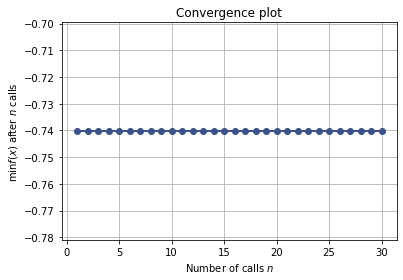

In [36]:
plot_convergence(fm_)

We see that for some reason, the search focuses on models with low n_estimators, and probably because of this, it does not manage to find the best hyperparameters, that return a better accuracy.

## The search class

In [37]:
# all together in one dataframe, so we can investigate further

gp_bayesian_results = pd.concat([
    pd.DataFrame(fm_.x_iters),
    pd.Series(fm_.func_vals),
], axis=1)

gp_bayesian_results.columns = dim_names + ['accuracy']
gp_bayesian_results.sort_values(by='accuracy', ascending=True, inplace=True)

# tmp.sort_values(by='accuracy', ascending=False, inplace=True)
gp_bayesian_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
0,597,42,0.850787,gbtree,62.360134,-0.74025
27,313,41,0.483902,gbtree,92.492404,-0.74025
26,60,29,0.484204,gbtree,54.474237,-0.74025
24,383,5,0.484735,dart,58.915678,-0.74025
23,111,11,0.486842,dart,71.268693,-0.74025


## 5. Bayesian Optimization with GBM as surrogate

Sequential optimization using gradient boosted trees.

Gradient boosted regression trees are used to model the (very) expensive to evaluate function func. The model is improved by sequentially evaluating the expensive function at the next best point. Thereby finding the minimum of func with as few evaluations as possible.

In [38]:
# gbrt_minimize performs by Bayesian Optimization 
# using GBMs as surrogate for f(x)
start = time.time()

gbm_ = gbrt_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

end = time.time()
print(end - start)
gbm_bayesian_run_time = end - start

561.0993180274963


In [39]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gbm_.fun

'Best score=-0.7445'

Good value of the accuracy, similar to that obtained with GP and Random Search.

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

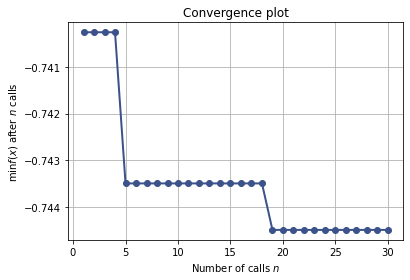

In [40]:
plot_convergence(gbm_)

In [41]:
# all together in one dataframe, so we can investigate further

gbm_bayesian_results = pd.concat([
    pd.DataFrame(gbm_.x_iters),
    pd.Series(gbm_.func_vals),
], axis=1)

gbm_bayesian_results.columns = dim_names + ['accuracy']
gbm_bayesian_results.sort_values(by='accuracy', ascending=True, inplace=True)

# tmp.sort_values(by='accuracy', ascending=False, inplace=True)
gbm_bayesian_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
18,883,2,0.349090,gbtree,2.853483,-0.74450
4,979,40,0.462250,gbtree,11.836260,-0.74350
26,830,3,0.118066,dart,3.797888,-0.74225
20,94,1,0.158393,gbtree,2.610103,-0.74050
0,553,36,0.600708,gbtree,42.371243,-0.74025


## OPTIONAL:  Using Optimizer

Use the Optimizer class directly when you want to control the optimization loop. We refer to this as the ask-and-tell interface. This class is used internally to implement the skopt’s top level minimization functions.

## Optimization with Gaussian Process

In [42]:
# We use the Optimizer

gp_optimizer = Optimizer(
    dimensions = param_grid, # the hyperparameter space
    base_estimator = "GP", # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    random_state=0, 
    n_jobs=4,
)

In [43]:
# we will use 4 CPUs (n_points)
# if we loop 10 times using 4 end points, we perform 40 searches in total
start = time.time()

for i in range(10):
    x = gp_optimizer.ask(n_points=3)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(objective)(v) for v in x)  # evaluate points in parallel
    gp_optimizer.tell(x, y)

end = time.time()
print(end - start)
optimized_gp_bayesian_run_time = end - start

800.0405342578888


In [45]:
# the evaluated hyperparamters

gp_optimizer.Xi

[[536, 34, 0.6202555575768482, 'gbtree', 85.87579572719736],
 [981, 7, 0.011604221491394147, 'gbtree', 24.236643021363218],
 [70, 27, 0.12327693424469754, 'gbtree', 90.72039968754787],
 [266, 49, 0.900269606196575, 'gbtree', 26.259800361315346],
 [171, 39, 0.5771131769273201, 'dart', 18.848211595097755],
 [421, 4, 0.281539078153369, 'gbtree', 62.6257457787331],
 [533, 4, 0.34543778018140453, 'dart', 24.053910599074918],
 [349, 32, 0.41040155161223124, 'gbtree', 32.27356885540677],
 [319, 24, 0.27855364396990406, 'dart', 67.80778718492887],
 [156, 39, 0.4705451595556588, 'dart', 81.79353636460371],
 [786, 4, 0.7689818481736821, 'dart', 47.34253520011302],
 [216, 4, 0.99, 'dart', 11.74171409034349],
 [1000, 39, 0.43500635685245737, 'dart', 100.0],
 [1000, 43, 0.7337730547035485, 'dart', 0.01],
 [742, 47, 0.839200789858305, 'gbtree', 0.1229642736176643],
 [521, 27, 0.7591257188253729, 'dart', 40.308815855045346],
 [276, 43, 0.3396264471087294, 'dart', 54.75597722512461],
 [1000, 1, 0.4562

In [46]:
# the accuracy

gp_optimizer.yi

[-0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.72325,
 -0.7402500000000001,
 -0.741,
 -0.7065,
 -0.67125,
 -0.66825,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.72325,
 -0.6739999999999999,
 -0.72775,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7065,
 -0.7402500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001]

In [47]:
# all together in one dataframe, so we can investigate further

optimized_gp_bayesian_results = pd.concat([
    pd.DataFrame(gp_optimizer.Xi),
    pd.Series(gp_optimizer.yi),
], axis=1)

optimized_gp_bayesian_results.columns = dim_names + ['accuracy']
optimized_gp_bayesian_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
0,536,34,0.620256,gbtree,85.875796,-0.74025
1,981,7,0.011604,gbtree,24.236643,-0.74025
2,70,27,0.123277,gbtree,90.720400,-0.70650
3,266,49,0.900270,gbtree,26.259800,-0.74025
4,171,39,0.577113,dart,18.848212,-0.74025


## Evaluate convergence of the search

In [48]:
optimized_gp_bayesian_results.sort_values(by='accuracy', ascending=True)

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
11,216,4,0.990000,dart,11.741714,-0.74100
0,536,34,0.620256,gbtree,85.875796,-0.74025
27,10,35,0.559035,dart,22.672076,-0.74025
25,169,1,0.498370,dart,67.068271,-0.74025
22,541,1,0.135846,dart,11.938837,-0.74025
21,942,19,0.990000,dart,85.863744,-0.74025
20,10,1,0.175284,dart,0.010000,-0.74025
16,276,43,0.339626,dart,54.755977,-0.74025
15,521,27,0.759126,dart,40.308816,-0.74025
28,764,7,0.558378,dart,44.191497,-0.74025


## 7. Optimization with RANDOM FOREST

In [49]:
# We use the Optimizer

rf_optimizer = Optimizer(
    dimensions = param_grid, # the hyperparameter space
    base_estimator = "RF", # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    random_state=0, 
    n_jobs=4,
)

In [50]:
# we will use 4 CPUs (n_points)
# if we loop 10 times using 4 end points, we perform 40 searches in total
start = time.time()

for i in range(10):
    x = rf_optimizer.ask(n_points=3)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(objective)(v) for v in x)  # evaluate points in parallel
    rf_optimizer.tell(x, y)

end = time.time()
print(end - start)
optimized_rf_bayesian_run_time = end - start

250.82361388206482


In [51]:
# the evaluated hyperparamters

rf_optimizer.Xi

[[536, 34, 0.6202555575768482, 'gbtree', 85.87579572719736],
 [981, 7, 0.011604221491394147, 'gbtree', 24.236643021363218],
 [70, 27, 0.12327693424469754, 'gbtree', 90.72039968754787],
 [266, 49, 0.900269606196575, 'gbtree', 26.259800361315346],
 [171, 39, 0.5771131769273201, 'dart', 18.848211595097755],
 [421, 4, 0.281539078153369, 'gbtree', 62.6257457787331],
 [533, 4, 0.34543778018140453, 'dart', 24.053910599074918],
 [349, 32, 0.41040155161223124, 'gbtree', 32.27356885540677],
 [319, 24, 0.27855364396990406, 'dart', 67.80778718492887],
 [156, 39, 0.4705451595556588, 'dart', 81.79353636460371],
 [14, 28, 0.15716243142797087, 'gbtree', 76.3755352552682],
 [147, 20, 0.1088341875451339, 'gbtree', 83.55956276984722],
 [214, 33, 0.09637783082362113, 'gbtree', 17.698926390858457],
 [190, 31, 0.03906542383800203, 'gbtree', 6.98397227606828],
 [166, 20, 0.2507415561716189, 'dart', 6.6314138233190505],
 [182, 44, 0.41795077450101803, 'gbtree', 78.928514488324],
 [173, 28, 0.5719242774545013,

In [52]:
# the accuracy

rf_optimizer.yi

[-0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.72325,
 -0.7065,
 -0.7065,
 -0.7402500000000001,
 -0.741,
 -0.7322500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.72325,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.7065,
 -0.7402500000000001]

In [53]:
# all together in one dataframe, so we can investigate further

optimized_rf_bayesian_results = pd.concat([
    pd.DataFrame(rf_optimizer.Xi),
    pd.Series(rf_optimizer.yi),
], axis=1)

optimized_rf_bayesian_results.columns = dim_names + ['accuracy']
optimized_rf_bayesian_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
0,536,34,0.620256,gbtree,85.875796,-0.74025
1,981,7,0.011604,gbtree,24.236643,-0.74025
2,70,27,0.123277,gbtree,90.720400,-0.70650
3,266,49,0.900270,gbtree,26.259800,-0.74025
4,171,39,0.577113,dart,18.848212,-0.74025


## Evaluate convergence of the search

# 8. OPTIMIZATION WITH GBM

In [54]:

# We use the Optimizer

gbm_optimizer = Optimizer(
    dimensions = param_grid, # the hyperparameter space
    base_estimator = "GBRT", # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    random_state=0, 
    n_jobs=4,
)

optimized_gbm_bayesian_run_time = end - start

In [55]:
# we will use 4 CPUs (n_points)
# if we loop 10 times using 4 end points, we perform 40 searches in total
start = time.time()

for i in range(10):
    x = gbm_optimizer.ask(n_points=3)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(objective)(v) for v in x)  # evaluate points in parallel
    gbm_optimizer.tell(x, y)

end = time.time()
print(end - start)
optimized_gbm_bayesian_run_time = end - start

716.6659710407257


In [56]:
# the evaluated hyperparamters

gbm_optimizer.Xi

[[536, 34, 0.6202555575768482, 'gbtree', 85.87579572719736],
 [981, 7, 0.011604221491394147, 'gbtree', 24.236643021363218],
 [70, 27, 0.12327693424469754, 'gbtree', 90.72039968754787],
 [266, 49, 0.900269606196575, 'gbtree', 26.259800361315346],
 [171, 39, 0.5771131769273201, 'dart', 18.848211595097755],
 [421, 4, 0.281539078153369, 'gbtree', 62.6257457787331],
 [533, 4, 0.34543778018140453, 'dart', 24.053910599074918],
 [349, 32, 0.41040155161223124, 'gbtree', 32.27356885540677],
 [319, 24, 0.27855364396990406, 'dart', 67.80778718492887],
 [156, 39, 0.4705451595556588, 'dart', 81.79353636460371],
 [682, 17, 0.15139925066488344, 'dart', 66.25887569725694],
 [70, 20, 0.7208925164995721, 'dart', 96.19050758873833],
 [565, 23, 0.20695072294706046, 'dart', 48.821115600834155],
 [867, 48, 0.16579353959654722, 'dart', 47.95239065384019],
 [208, 22, 0.15545606251208782, 'gbtree', 59.472025903947184],
 [728, 41, 0.4533977890779622, 'dart', 52.80562906316854],
 [517, 49, 0.5946435706183474, 'da

In [57]:
# the accuracy

gbm_optimizer.yi

[-0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.72325,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7065,
 -0.72325,
 -0.741,
 -0.72325,
 -0.7335,
 -0.70275,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7362500000000001,
 -0.741,
 -0.74275,
 -0.7402500000000001,
 -0.6737500000000001]

In [58]:
# all together in one dataframe, so we can investigate further

optimized_gbm_bayesian_results = pd.concat([
    pd.DataFrame(gbm_optimizer.Xi),
    pd.Series(gbm_optimizer.yi),
], axis=1)

optimized_gbm_bayesian_results.columns = dim_names + ['accuracy']
optimized_gbm_bayesian_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
0,536,34,0.620256,gbtree,85.875796,-0.74025
1,981,7,0.011604,gbtree,24.236643,-0.74025
2,70,27,0.123277,gbtree,90.720400,-0.70650
3,266,49,0.900270,gbtree,26.259800,-0.74025
4,171,39,0.577113,dart,18.848212,-0.74025


## Evaluate convergence of the search

# 9. optimization with random search

In [59]:
# We use the Optimizer

random_optimizer = Optimizer(
    dimensions = param_grid, # the hyperparameter space
    base_estimator = "DUMMY", # the surrogate
    n_initial_points=10, # the number of points to evaluate f(x) to start of
    acq_func='EI', # the acquisition function
    random_state=0, 
    n_jobs=4,
)

In [60]:
# we will use 4 CPUs (n_points)
# if we loop 10 times using 4 end points, we perform 40 searches in total
start = time.time()

for i in range(10):
    x = random_optimizer.ask(n_points=3)  # x is a list of n_points points
    y = Parallel(n_jobs=4)(delayed(objective)(v) for v in x)  # evaluate points in parallel
    random_optimizer.tell(x, y)

end = time.time()
print(end - start)
optimized_random_search_run_time = end - start

804.4486119747162


In [61]:
# the evaluated hyperparamters

random_optimizer.Xi

[[536, 34, 0.6202555575768482, 'gbtree', 85.87579572719736],
 [981, 7, 0.011604221491394147, 'gbtree', 24.236643021363218],
 [70, 27, 0.12327693424469754, 'gbtree', 90.72039968754787],
 [266, 49, 0.900269606196575, 'gbtree', 26.259800361315346],
 [171, 39, 0.5771131769273201, 'dart', 18.848211595097755],
 [421, 4, 0.281539078153369, 'gbtree', 62.6257457787331],
 [533, 4, 0.34543778018140453, 'dart', 24.053910599074918],
 [349, 32, 0.41040155161223124, 'gbtree', 32.27356885540677],
 [319, 24, 0.27855364396990406, 'dart', 67.80778718492887],
 [156, 39, 0.4705451595556588, 'dart', 81.79353636460371],
 [682, 42, 0.3230504099339517, 'dart', 11.06970651690319],
 [299, 8, 0.29983730925676766, 'dart', 25.580591822273323],
 [240, 13, 0.7236175653975022, 'dart', 18.11783023187267],
 [261, 2, 0.039126355980053366, 'dart', 26.04667463325948],
 [631, 26, 0.2934797338928394, 'gbtree', 87.04009313950871],
 [840, 50, 0.7287385693054261, 'dart', 33.34870480317856],
 [287, 43, 0.7620804677537625, 'dart'

In [62]:
# the accuracy

random_optimizer.yi

[-0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.72325,
 -0.741,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.6935,
 -0.7065,
 -0.7402500000000001,
 -0.7402500000000001,
 -0.7065,
 -0.7065,
 -0.7365,
 -0.7402500000000001,
 -0.72325]

In [63]:
# all together in one dataframe, so we can investigate further

optimized_random_search_results = pd.concat([
    pd.DataFrame(random_optimizer.Xi),
    pd.Series(random_optimizer.yi),
], axis=1)

optimized_random_search_results.columns = dim_names + ['accuracy']
optimized_random_search_results.head()

,n_estimators,max_depth,learning_rate,booster,gamma,accuracy
0,536,34,0.620256,gbtree,85.875796,-0.74025
1,981,7,0.011604,gbtree,24.236643,-0.74025
2,70,27,0.123277,gbtree,90.720400,-0.70650
3,266,49,0.900270,gbtree,26.259800,-0.74025
4,171,39,0.577113,dart,18.848212,-0.74025
